## Análise de Sentimento em Avaliações de Produtos

- #### Curso: Pós-Graduação em Deep Learning (CIn - UFPE)
- ##### Disciplina: Processamento de Linguagem Natural  
  - ##### Professor: Luciano Barbosa
  - ##### Aluno: Francisco Adaías Gomes da Silva

##Projeto de NLP

O objetivo deste projeto é coletar avaliações de um produto selecionado, contendo texto e nota e treinar classificadores de forma a avaliar suas performances. Os classificadores deverão ser:

    SVM + bow
    SVM + embeddings
    BERT
    In-Context Learning

Além disso cada classificador deve ser analisado através de métricas de performance como acurácia, F1-score, precision, recall e etc.

# 1. Carregamento dos Dados

In [6]:
pip install contractions

In [7]:
pip install xgboost

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import contractions
import re
from nltk.corpus import stopwords
import time
from nltk.stem import PorterStemmer

In [9]:
plt.style.use('fivethirtyeight')
ps = PorterStemmer()

### Dataset - Netflix Reviews

Este conjunto de dados compreende informações detalhadas sobre as avaliações feitas pelos usuários da Netflix na Google Play Store. As avaliações fornecem insights valiosos sobre a opinião dos usuários em relação ao aplicativo da Netflix. Cada registro no conjunto de dados inclui a avaliação textual do usuário, permitindo uma análise qualitativa das opiniões expressas.

Além das avaliações textuais, o conjunto de dados contém as classificações numéricas atribuídas pelos usuários, que variam de 1 a 5 estrelas. Essas classificações oferecem uma visão quantitativa da satisfação geral dos usuários.

Com essas informações, é possível realizar uma variedade de análises, como a identificação de padrões de satisfação, a detecção de problemas recorrentes mencionados pelos usuários e a avaliação do impacto de novas funcionalidades ou atualizações do aplicativo da Netflix.

Link do Dataset: https://www.kaggle.com/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated

In [10]:
import pandas as pd

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishkumarak/netflix-reviews-playstore-daily-updated")

print("Path to dataset files:", path)

100%|██████████| 13.3M/13.3M [00:00<00:00, 61.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated/versions/231


In [13]:
import pandas as pd
from IPython.display import display

# Carrega o arquivo CSV em um DataFrame do pandas
df = pd.read_csv(f"{path}/netflix_reviews.csv")

# Exibe as primeiras linhas do DataFrame de forma organizada
print("Primeiras linhas do DataFrame:")
display(df.head())

# Exibe informações gerais sobre o DataFrame
print("\nInformações gerais do DataFrame:")
display(df.info())

# Exibe estatísticas descritivas básicas do DataFrame
print("\nEstatísticas descritivas do DataFrame:")
display(df.describe())

# Exibe a contagem de valores únicos em cada coluna
print("\nContagem de valores únicos em cada coluna:")
display(df.nunique())


Primeiras linhas do DataFrame:


,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,3096ecf3-90a9-4dca-9819-429dee019a31,Imad Ahmed,"The quality gets limited to SD , even though m...",1,0,8.97.1 build 11 50573,2024-12-26 16:05:14,8.97.1 build 11 50573
1,3d498d72-5737-49f5-85b3-d397d3458cf7,Ivan Garcia,I Love,5,0,8.141.1 build 13 51230,2024-12-26 16:02:59,8.141.1 build 13 51230
2,dc116957-a9f0-46a6-bd8f-add30acffd9d,mazliza hanizar,ilove it sooooooooooo muchhhh,5,0,NaN,2024-12-26 15:52:42,NaN
3,eb581df8-c2d9-4b59-8154-e4130cd7b1b8,Nikita Kurhade,Jay bhim,4,0,8.130.0 build 3 50815,2024-12-26 15:51:36,8.130.0 build 3 50815
4,c4c89d8c-77e6-4967-948d-6b51909ab545,Ross,Son of God is pure English x,5,0,8.141.1 build 13 51230,2024-12-26 15:48:03,8.141.1 build 13 51230



Informações gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122868 entries, 0 to 122867
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              122868 non-null  object
 1   userName              122866 non-null  object
 2   content               122864 non-null  object
 3   score                 122868 non-null  int64 
 4   thumbsUpCount         122868 non-null  int64 
 5   reviewCreatedVersion  103730 non-null  object
 6   at                    122868 non-null  object
 7   appVersion            103730 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.5+ MB


None


Estatísticas descritivas do DataFrame:


,score,thumbsUpCount
count,122868.000000,122868.000000
mean,2.830062,9.735554
std,1.711884,97.620031
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8032.000000



Contagem de valores únicos em cada coluna:


,0
reviewId,122109
userName,88940
content,119841
score,5
thumbsUpCount,904
reviewCreatedVersion,595
at,122524
appVersion,595


In [15]:
# Carrega o arquivo CSV em um DataFrame do pandas
df = pd.read_csv(f"{path}/netflix_reviews.csv")

# Exibe as primeiras linhas do DataFrame
print(df.head())


                               reviewId         userName  \
0  3096ecf3-90a9-4dca-9819-429dee019a31       Imad Ahmed   
1  3d498d72-5737-49f5-85b3-d397d3458cf7      Ivan Garcia   
2  dc116957-a9f0-46a6-bd8f-add30acffd9d  mazliza hanizar   
3  eb581df8-c2d9-4b59-8154-e4130cd7b1b8   Nikita Kurhade   
4  c4c89d8c-77e6-4967-948d-6b51909ab545             Ross   

                                             content  score  thumbsUpCount  \
0  The quality gets limited to SD , even though m...      1              0   
1                                             I Love      5              0   
2                      ilove it sooooooooooo muchhhh      5              0   
3                                           Jay bhim      4              0   
4                       Son of God is pure English x      5              0   

     reviewCreatedVersion                   at              appVersion  
0   8.97.1 build 11 50573  2024-12-26 16:05:14   8.97.1 build 11 50573  
1  8.141.1 build 13 5123

In [16]:
# Exibe tipos de dados de cada coluna
print("\nTipos de dados de cada coluna:")
df.info()


Tipos de dados de cada coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122868 entries, 0 to 122867
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              122868 non-null  object
 1   userName              122866 non-null  object
 2   content               122864 non-null  object
 3   score                 122868 non-null  int64 
 4   thumbsUpCount         122868 non-null  int64 
 5   reviewCreatedVersion  103730 non-null  object
 6   at                    122868 non-null  object
 7   appVersion            103730 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.5+ MB


In [17]:
# Imprime um describe detalhado, incluindo todas as colunas
print("\nDescrição detalhada dos dados:")
print(df.describe(include='all'))


Descrição detalhada dos dados:
                                    reviewId       userName content  \
count                                 122868         122866  122864   
unique                                122109          88940  119841   
top     ef9bf390-40f4-4c18-8726-fa2246c83a36  A Google user    Good   
freq                                      12          30213     608   
mean                                     NaN            NaN     NaN   
std                                      NaN            NaN     NaN   
min                                      NaN            NaN     NaN   
25%                                      NaN            NaN     NaN   
50%                                      NaN            NaN     NaN   
75%                                      NaN            NaN     NaN   
max                                      NaN            NaN     NaN   

                score  thumbsUpCount   reviewCreatedVersion  \
count   122868.000000  122868.000000                

In [18]:
# Estatísticas descritivas para variáveis categóricas
print("\nEstatísticas descritivas para variáveis categóricas:")
print(df.describe(include=['object']))


Estatísticas descritivas para variáveis categóricas:
                                    reviewId       userName content  \
count                                 122868         122866  122864   
unique                                122109          88940  119841   
top     ef9bf390-40f4-4c18-8726-fa2246c83a36  A Google user    Good   
freq                                      12          30213     608   

         reviewCreatedVersion                   at             appVersion  
count                  103730               122868                 103730  
unique                    595               122524                    595  
top     7.84.1 build 28 35243  2024-05-17 00:07:38  7.84.1 build 28 35243  
freq                     1912                    3                   1912  


# 2. Pré-processamento dos Dados

Nesta fase, utilizamos a biblioteca nltk (Natural Language Toolkit) para realizar várias tarefas de limpeza e preparação dos dados textuais. Abaixo, detalhamos os principais passos de pré-processamento.

Tokenização

Tokenização é o processo de dividir um texto em unidades menores, como palavras ou frases. Isso é importante para analisar e processar o texto de forma mais granular. Usamos a função word_tokenize do nltk para realizar essa tarefa.

Remoção de Stopwords

Stopwords são palavras comuns que geralmente não agregam muito significado ao texto, como "e", "o", "a", "de". Removê-las pode ajudar a focar nas palavras mais significativas. Utilizamos a lista de stopwords fornecida pelo nltk.


In [19]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import string
import pandas as pd  # Ensure pandas is imported

# Faz o download das stopwords
nltk.download("stopwords")
stop_words = stopwords.words("portuguese")

# Função para pré-processar o texto
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Retorna string vazia se o texto não for string
    text = text.lower()  # Converte para minúsculas
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove pontuação
    text = "".join([char for char in text if char.isalnum() or char.isspace()])  # Remove caracteres não alfanuméricos
    tokens = [word for word in text.split() if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)  # Junta os tokens de volta em uma string

# Carregar o dataset
path = kagglehub.dataset_download("ashishkumarak/netflix-reviews-playstore-daily-updated")
df = pd.read_csv(f"{path}/netflix_reviews.csv")

# Verifica e remove linhas com review ou rating vazio antes de qualquer processamento
empty_reviews = df["content"].isnull() | (df["content"].astype(str).str.strip() == "")
empty_ratings = df["score"].isnull() | (df["score"].astype(str).str.strip() == "")
initial_count = df.shape[0]
df = df[~(empty_reviews | empty_ratings)].copy()
removed_reviews = initial_count - df.shape[0]

# Exibe a quantidade de reviews e ratings vazios removidos
print("\nItens Removidos:")
print("Reviews ou Ratings vazios:", removed_reviews)

# Converte a coluna 'score' para inteiro, tratando possíveis erros
df["score"] = pd.to_numeric(df["score"], errors='coerce')

# Remove quaisquer linhas onde a conversão falhou (resultado em NaN)
invalid_ratings = df["score"].isnull()
if invalid_ratings.any():
    print(f"Removendo {invalid_ratings.sum()} linhas com ratings inválidos após conversão.")
    df = df[~invalid_ratings]

# Aplica a função de pré-processamento à coluna 'content'
df["clean_review"] = df["content"].apply(preprocess_text)

# Função para converter notas em rótulos de sentimento
def convert_to_sentiment(score):
    if score >= 4:
        return "positivo"
    elif score <= 2:
        return "negativo"
    else:
        return "neutro"

# Aplica a função de conversão à coluna 'score'
df["sentiment"] = df["score"].apply(convert_to_sentiment)

# Opcional: Exibe um resumo das conversões
print("\nDistribuição de Sentimentos:")
print(df["sentiment"].value_counts())

# Exemplo de visualização do DataFrame resultante
print("\nExemplo de dados processados:")
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Itens Removidos:
Reviews ou Ratings vazios: 4

Distribuição de Sentimentos:
sentiment
negativo    59587
positivo    50720
neutro      12557
Name: count, dtype: int64

Exemplo de dados processados:
                               reviewId         userName  \
0  3096ecf3-90a9-4dca-9819-429dee019a31       Imad Ahmed   
1  3d498d72-5737-49f5-85b3-d397d3458cf7      Ivan Garcia   
2  dc116957-a9f0-46a6-bd8f-add30acffd9d  mazliza hanizar   
3  eb581df8-c2d9-4b59-8154-e4130cd7b1b8   Nikita Kurhade   
4  c4c89d8c-77e6-4967-948d-6b51909ab545             Ross   

                                             content  score  thumbsUpCount  \
0  The quality gets limited to SD , even though m...      1              0   
1                                             I Love      5              0   
2                      ilove it sooooooooooo muchhhh      5              0   
3                                           Jay bhim      4              0   
4                       Son of God is pure English 

# 3. Análise Descritiva

## 3.1. Distribuição das Notas (rating)

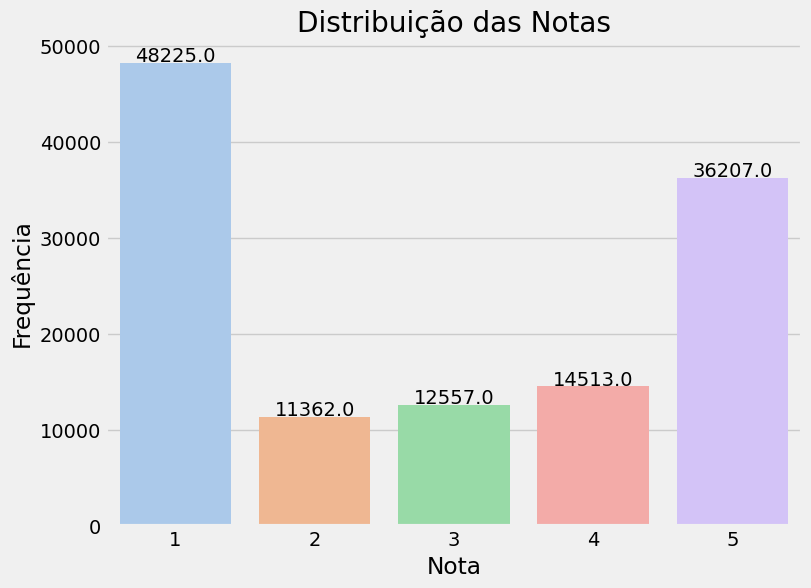

In [20]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Análise da Distribuição das Notas
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='score', data=df, hue='score', palette='pastel', legend=False)  # Usando a coluna 'score'

# Adiciona os totais em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribuição das Notas')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()


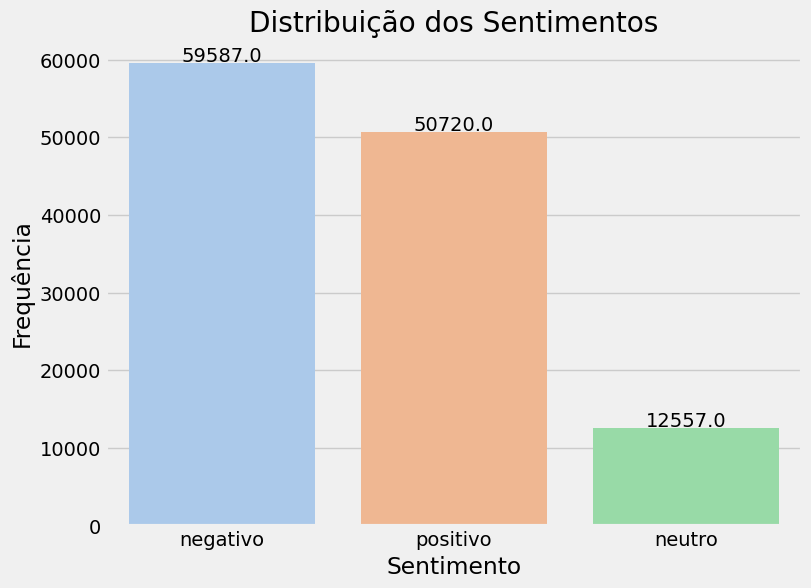

In [21]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Análise da Distribuição dos Sentimentos
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment', data=df, hue='sentiment', palette='pastel', legend=False)  # Usando a coluna 'sentiment'

# Adiciona os totais em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribuição dos Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.show()


### Resultados Totais da Distribuição das Notas

In [22]:
# Imprime os totais para cada nota
print("\nResultados Totais da Distribuição das Notas:")
rating_counts = df['score'].value_counts().sort_index()
for rating, count in rating_counts.items():
    print(f"Nota {rating}: {count} avaliações")


Resultados Totais da Distribuição das Notas:
Nota 1: 48225 avaliações
Nota 2: 11362 avaliações
Nota 3: 12557 avaliações
Nota 4: 14513 avaliações
Nota 5: 36207 avaliações


## 3.2. Histograma do Comprimento das Avaliações (review)


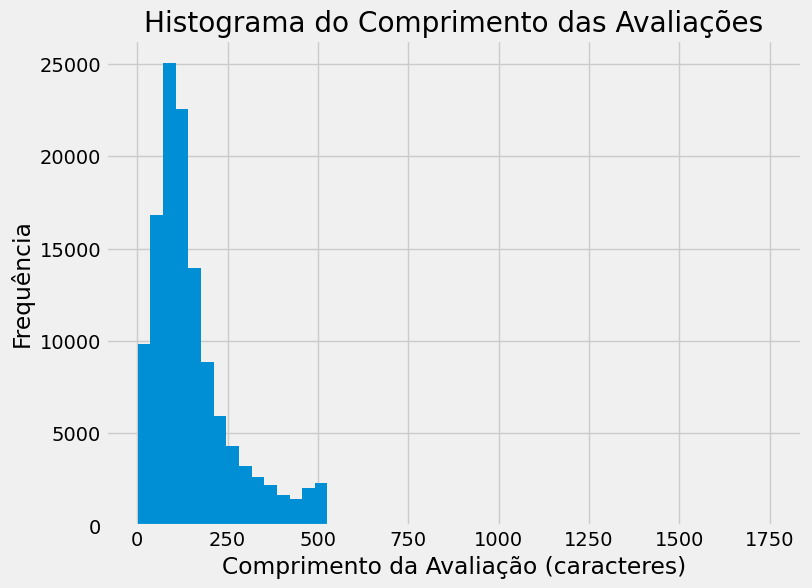

In [23]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['content'].str.len(), bins=50)
plt.title('Histograma do Comprimento das Avaliações')
plt.xlabel('Comprimento da Avaliação (caracteres)')
plt.ylabel('Frequência')
plt.show()

### Estatísticas do Comprimento das Avaliações

In [24]:
import pandas as pd
import numpy as np

review_lengths = df['content'].str.len()
hist, bin_edges = np.histogram(review_lengths, bins=50) # Calculate hist and bin_edges

# Cria um DataFrame para estatísticas resumidas
summary_data = {
    "Métrica": ["Total de Avaliações", "Comprimento Médio", "Comprimento Mínimo", "Comprimento Máximo", "Desvio Padrão"],
    "Valor": [
        len(review_lengths),
        f"{review_lengths.mean():.2f} caracteres",
        f"{review_lengths.min()} caracteres",
        f"{review_lengths.max()} caracteres",
        f"{review_lengths.std():.2f} caracteres",
    ],
}
summary_df = pd.DataFrame(summary_data)

# Cria um DataFrame para a distribuição de comprimentos
distribution_data = {
    "Intervalo de Comprimento": [f"{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}" for i in range(len(hist))],
    "Frequência (Avaliações)": hist,
}
distribution_df = pd.DataFrame(distribution_data)

# Exibe as tabelas
print("Estatísticas Resumidas:")
print(summary_df.to_string(index=False))  # index=False para ocultar os números das linhas

print("\nDistribuição de Comprimentos:")
print(distribution_df.to_string(index=False))

Estatísticas Resumidas:
            Métrica             Valor
Total de Avaliações            122864
  Comprimento Médio 151.78 caracteres
 Comprimento Mínimo      1 caracteres
 Comprimento Máximo   1752 caracteres
      Desvio Padrão 113.47 caracteres

Distribuição de Comprimentos:
Intervalo de Comprimento  Frequência (Avaliações)
                    1-36                     9811
                   36-71                    16817
                  71-106                    25060
                 106-141                    22581
                 141-176                    13969
                 176-211                     8839
                 211-246                     5930
                 246-281                     4307
                 281-316                     3201
                 316-351                     2645
                 351-386                     2181
                 386-421                     1633
                 421-456                     1426
                 

## 3.4 Frequência das Entidades (review)


In [25]:
# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [26]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import spacy

import plotly.express as px

# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

# Carregamento do modelo de linguagem do spaCy
nlp = spacy.load('pt_core_news_md')

# Carregue o DataFrame (supondo que o DataFrame já esteja carregado de algum arquivo CSV ou banco de dados)
# Aqui você pode testar com um subconjunto de 1.000 linhas para acelerar o desenvolvimento
df_sample = df.sample(1000)  # Teste com um subconjunto de 1.000 linhas

# Pré-processamento com spaCy
def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    return ' '.join(tokens)

df_sample['clean_review'] = df_sample['content'].astype(str).apply(preprocess)

# Análise de Entidades Nomeadas com spaCy
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'LOC', 'PRODUCT']]

df_sample['entities'] = df_sample['content'].astype(str).apply(extract_entities)

# Contagem das entidades mais frequentes
all_entities = [entity for sublist in df_sample['entities'] for entity in sublist]
entity_freq = Counter(all_entities).most_common(20)

# Agora, você pode continuar com as análises e visualizações normalmente usando df_sample


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 11.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<ipython-input-27-05120e423cc6>:8: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


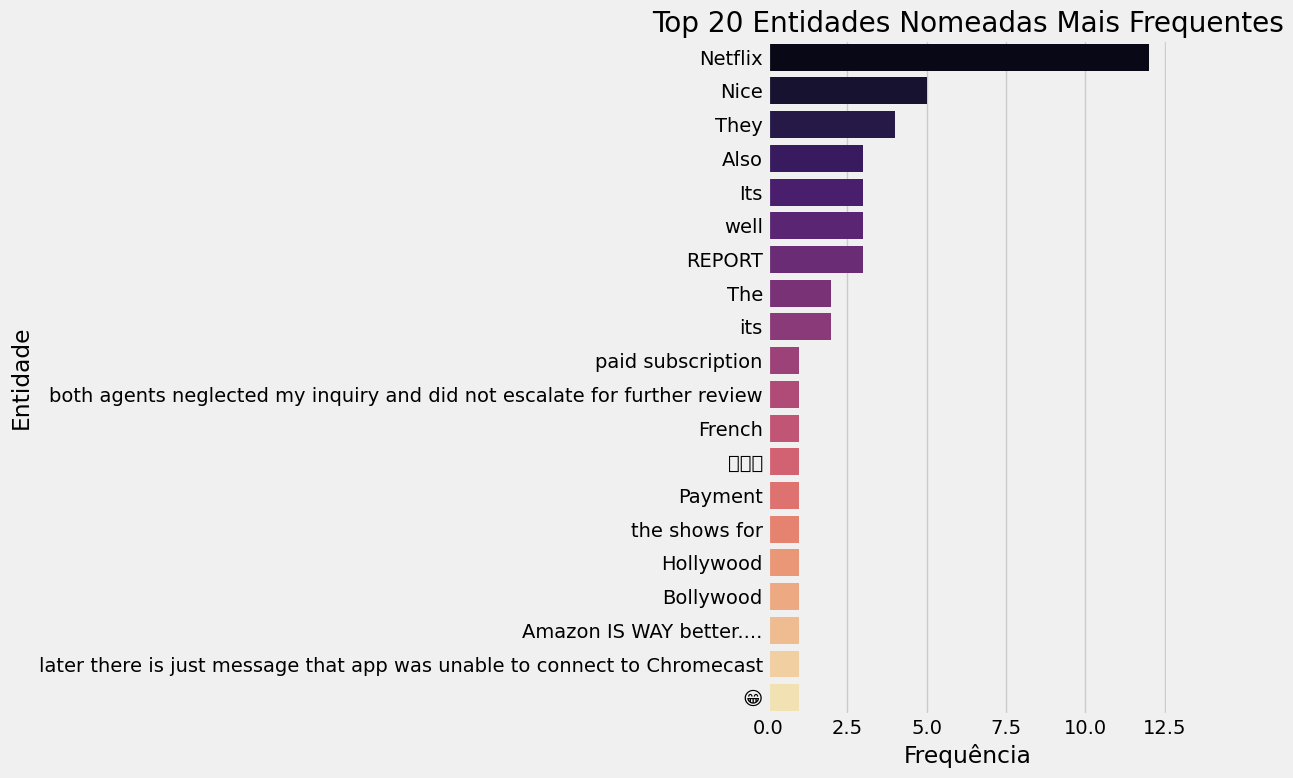

In [27]:
# Visualização: Frequência das Entidades
entities_df = pd.DataFrame(entity_freq, columns=['Entidade', 'Frequência'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequência', y='Entidade', data=entities_df, palette='magma', hue='Entidade', dodge=False)  # Modified line
plt.title('Top 20 Entidades Nomeadas Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Entidade')
plt.tight_layout()
plt.show()

## 3.6 Análise do Comprimento da Avaliação vs. Nota com Regressão

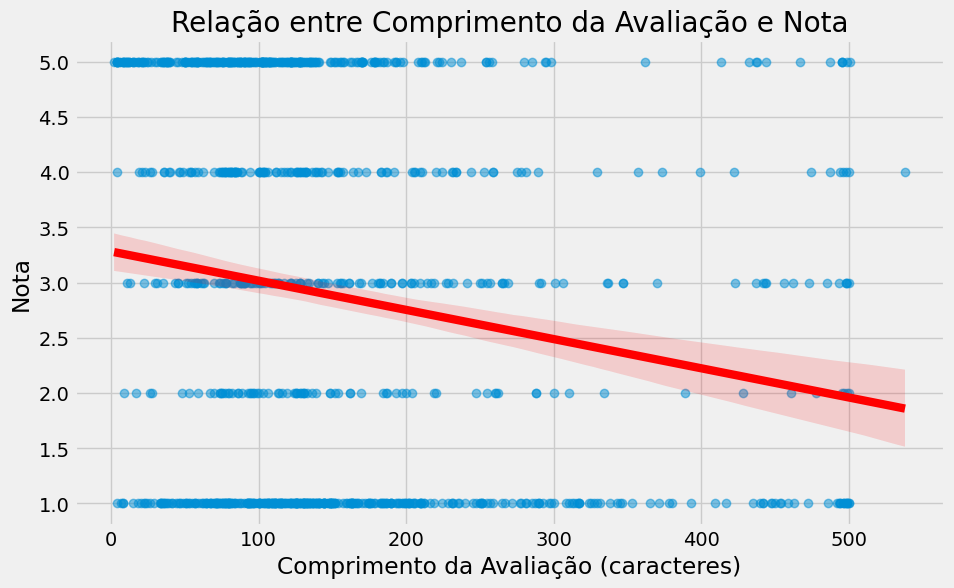

In [28]:
# Adicionando a coluna de comprimento da avaliação
df_sample['review_length'] = df_sample['content'].astype(str).apply(len)

# Análise do Comprimento da Avaliação vs. Nota com Regressão
plt.figure(figsize=(10, 6))
sns.regplot(x='review_length', y='score', data=df_sample, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Relação entre Comprimento da Avaliação e Nota')
plt.xlabel('Comprimento da Avaliação (caracteres)')
plt.ylabel('Nota')
plt.show()


### Correlação entre Comprimento da Avaliação e Nota

In [29]:
# Calcular e imprimir a correlação usando o subconjunto de dados (df_sample)
correlation = df_sample['review_length'].corr(df_sample['score'])
print("-" * 50)
print(f"Coeficiente de correlação de Pearson: {correlation:.2f}")
print("-" * 50)


--------------------------------------------------
Coeficiente de correlação de Pearson: -0.18
--------------------------------------------------


# 4. Treinamento de Classificadores

## 4.1 SVM + Bag of Words (BoW)

In [30]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Usar um subconjunto de 1.000 linhas do dataframe
df_sample = df.sample(1000, random_state=42)

# Divide o dataset
X_train, X_test, y_train, y_test = train_test_split(df_sample["clean_review"], df_sample["score"], test_size=0.2, random_state=42)

# Atualiza a pipeline usando TF-IDF no lugar de CountVectorizer
pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", SVC())
])

# Grade de parâmetros para o GridSearch
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_features": [1000, 3000, 5000],
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"]
}

# Aplica o GridSearch para encontrar a melhor combinação de hiperparâmetros
grid_search = GridSearchCV(pipeline_tfidf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtém o melhor modelo
best_svm_model = grid_search.best_estimator_

# Faz a predição no conjunto de teste
y_pred = best_svm_model.predict(X_test)

# Imprime métricas de avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.545
F1 Score (weighted): 0.5046504221833169

Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.81      0.70        74
           2       0.07      0.06      0.06        18
           3       0.20      0.14      0.16        22
           4       0.00      0.00      0.00        22
           5       0.68      0.70      0.69        64

    accuracy                           0.55       200
   macro avg       0.31      0.34      0.32       200
weighted avg       0.48      0.55      0.50       200



### Avaliação dos Resultados para o SVM + Bag of Words (BoW)

In [31]:
# Avaliação
print("SVM + TF-IDF")
print(classification_report(y_test, y_pred))

# Calcula a acurácia e F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")


SVM + TF-IDF
              precision    recall  f1-score   support

           1       0.62      0.81      0.70        74
           2       0.07      0.06      0.06        18
           3       0.20      0.14      0.16        22
           4       0.00      0.00      0.00        22
           5       0.68      0.70      0.69        64

    accuracy                           0.55       200
   macro avg       0.31      0.34      0.32       200
weighted avg       0.48      0.55      0.50       200

Accuracy: 0.545
F1-score: 0.5046504221833169


### Matriz de Confusão para o SVM + Bag of Words (BoW)

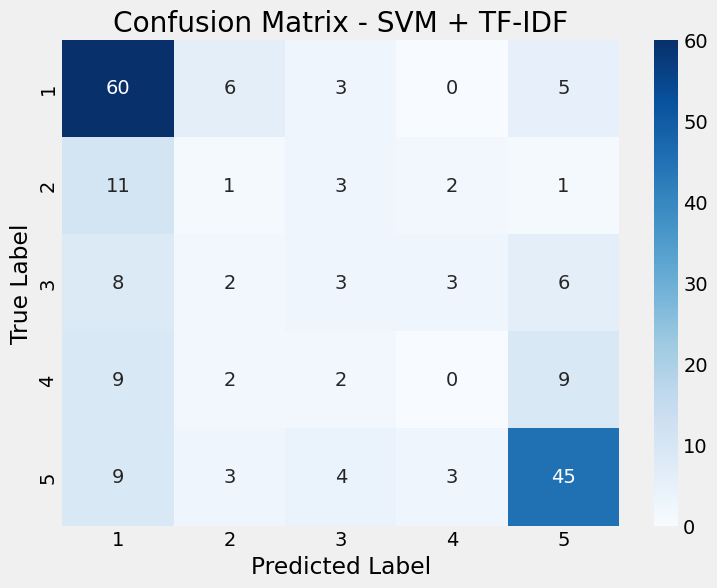

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np  # Adiciona importação de numpy

# Função para criar um heatmap da matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plota a matriz de confusão para o modelo SVM + TF-IDF
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix - SVM + TF-IDF")


## 4.2 SVM + Embeddings

Uso de `spacy` para converter as avaliações em embeddings e treinar o SVM com esses vetores.

In [33]:
# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

import spacy
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Usa embeddings do spaCy
nlp = spacy.load("pt_core_news_md")
X_train_embedded = [nlp(text).vector for text in X_train]
X_test_embedded = [nlp(text).vector for text in X_test]

# Normaliza os embeddings
scaler = StandardScaler()
X_train_embedded = scaler.fit_transform(X_train_embedded)
X_test_embedded = scaler.transform(X_test_embedded)

# Treina o SVM com embeddings
svm_embedding = SVC()
svm_embedding.fit(X_train_embedded, y_train)
y_pred_embed = svm_embedding.predict(X_test_embedded)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 12.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Avaliação dos Resultados para o SVM + Embeddings

In [34]:
# Avaliação
print("SVM + Embeddings")
print(classification_report(y_test, y_pred_embed))

# Calcula a acurácia e F1 score
accuracy_embed = accuracy_score(y_test, y_pred_embed)
f1_embed = f1_score(y_test, y_pred_embed, average='weighted')

print(f"Accuracy: {accuracy_embed}")
print(f"F1-score: {f1_embed}")

SVM + Embeddings
              precision    recall  f1-score   support

           1       0.48      0.82      0.61        74
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        22
           5       0.61      0.70      0.65        64

    accuracy                           0.53       200
   macro avg       0.22      0.31      0.25       200
weighted avg       0.37      0.53      0.43       200

Accuracy: 0.53
F1-score: 0.43439565217391307


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Matriz de Confusão para o SVM + Embedding

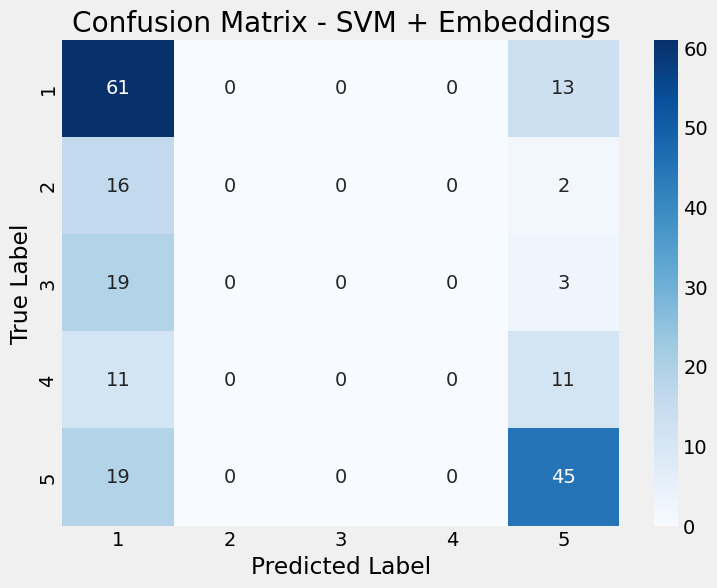

In [35]:
plot_confusion_matrix(y_test, y_pred_embed, title="Confusion Matrix - SVM + Embeddings")

## 4.3 BERT para Classificação

Usando `transformers` para fine-tuning de um modelo BERT para classificação de sentimentos.

In [36]:
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay

import tensorflow as tf

# Restringe o TensorFlow para usar apenas a CPU
# tf.config.set_visible_devices([], 'GPU')

# Prepara o modelo BERT
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = TFBertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=5)

# Tokeniza os dados
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="tf")
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="tf")

# Define o otimizador e a função de perda
optimizer = AdamWeightDecay(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

# Loop de treinamento personalizado
def train_step(inputs, targets):
    # Subtrai 1 dos targets para ajustar o intervalo para 0-4
    targets = targets - 1
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions.logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    metrics.update_state(targets, predictions.logits)
    return loss, metrics.result()

# Loop de Treinamento
epochs = 4
batch_size = 8
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        batch_inputs = {k: v[i:i + batch_size] for k, v in X_train_tokens.data.items()}
        batch_targets = y_train[i:i + batch_size]
        # Subtraindo 1 dos targets para ajustar o intervalo para 0-4
        loss, accuracy = train_step(batch_inputs, batch_targets)
        print(f"Batch {i // batch_size + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/4
Batch 1: Loss = 1.6503, Accuracy = 0.0000
Batch 2: Loss = 1.6096, Accuracy = 0.0625
Batch 3: Loss = 1.5349, Accuracy = 0.1667
Batch 4: Loss = 1.4892, Accuracy = 0.1875
Batch 5: Loss = 1.5571, Accuracy = 0.2250
Batch 6: Loss = 1.3357, Accuracy = 0.3125
Batch 7: Loss = 1.6078, Accuracy = 0.2857
Batch 8: Loss = 1.4709, Accuracy = 0.3125
Batch 9: Loss = 1.3467, Accuracy = 0.3472
Batch 10: Loss = 1.8012, Accuracy = 0.3125
Batch 11: Loss = 1.4348, Accuracy = 0.3295
Batch 12: Loss = 1.5443, Accuracy = 0.3125
Batch 13: Loss = 1.7525, Accuracy = 0.3077
Batch 14: Loss = 1.3620, Accuracy = 0.3125
Batch 15: Loss = 1.3181, Accuracy = 0.3167
Batch 16: Loss = 1.4656, Accuracy = 0.3203
Batch 17: Loss = 1.4012, Accuracy = 0.3309
Batch 18: Loss = 1.4134, Accuracy = 0.3333
Batch 19: Loss = 1.3416, Accuracy = 0.3289
Batch 20: Loss = 1.3379, Accuracy = 0.3438
Batch 21: Loss = 1.5091, Accuracy = 0.3512
Batch 22: Loss = 1.4595, Accuracy = 0.3580
Batch 23: Loss = 1.2975, Accuracy = 0.3696
Batch 24: 

### Avaliação dos Resultados para o BERT

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Avaliação
predictions = model(X_test_tokens.data).logits

# Obtém os rótulos previstos a partir dos logits
predicted_labels = np.argmax(predictions, axis=1)

# Ajusta y_test para o intervalo 0-4 para avaliação (se necessário)
y_test_adjusted = y_test - 1

# Calcula as métricas
accuracy_bert = accuracy_score(y_test_adjusted, predicted_labels)
f1_bert = f1_score(y_test_adjusted, predicted_labels, average='weighted')
loss = loss_fn(y_test_adjusted, predictions) # Calcula a perda após o ajuste do y_test

print("\nBERT:")
print(f"Test Loss: {loss:.4f}") # Imprime a perda
print(f"Acurácia: {accuracy_bert:.4f}")
print(f"F1 Score: {f1_bert:.4f}")


BERT:
Test Loss: 1.2749
Acurácia: 0.5800
F1 Score: 0.5235


### Matriz de Confusão para o Resultado do BERT

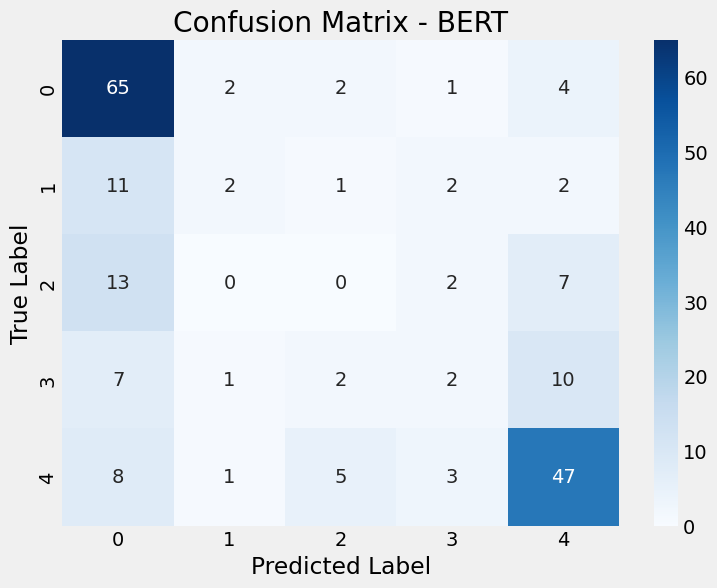

In [38]:
# ### Matriz de Confusão para o Resultado do BERT
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the confusion matrix for the BERT model
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test_adjusted, predicted_labels, title="Confusion Matrix - BERT")

# 5. Comparativo de Métricas e Resultados

Resultado comparativo entre os três modelos (SVM + BoW, SVM + Embebddings e BERT).

In [40]:
# Supõe que as variáveis accuracy_tfidf e f1_tfidf foram calculadas corretamente anteriormente
accuracy_tfidf = accuracy_score(y_test, y_pred)
f1_tfidf = f1_score(y_test, y_pred, average='weighted')

# Cria um dicionário com os resultados
resultados = {
    "Modelo": ["SVM + TF-IDF", "SVM + Embeddings", "BERT"],
    "Acurácia": [accuracy_tfidf, accuracy_embed, accuracy_bert],
    "F1-Score": [f1_tfidf, f1_embed, f1_bert]
}

# Cria um DataFrame pandas com os resultados
df_resultados = pd.DataFrame(resultados)

# Exibe o DataFrame
print(df_resultados)


             Modelo  Acurácia  F1-Score
0      SVM + TF-IDF     0.545  0.504650
1  SVM + Embeddings     0.530  0.434396
2              BERT     0.580  0.523452


### Gráfico com Comparação de Desempenho dos Modelos

<Figure size 500x300 with 0 Axes>

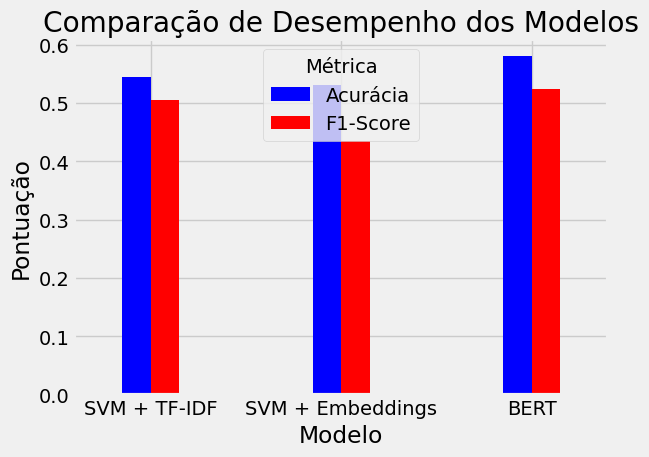

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5, 3))
df_resultados.plot(x="Modelo", y=["Acurácia", "F1-Score"], kind="bar", width=0.3, color=['blue', 'red'])
plt.title("Comparação de Desempenho dos Modelos")
plt.ylabel("Pontuação")
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()

# 6. Classificação com In-Context Learning (Bônus)

Utilizando LLM para realizar a classificação de sentimentos diretamente com poucas instruções, sem a necessidade de treinamento explícito.

In [46]:
# Define o temeplate do prompt
prompt_template = """
Você é um assistente de análise de sentimentos. Sua tarefa é classificar avaliações de produtos como "positivo", "negativo" ou "neutro".

Aqui está uma avaliação de um produto:
{review_text}

Classifique a avaliação acima como "Positivo", "Neutro" ou "Negativo". Responda apenas com a classificação, sem adicionar comentários ou explicações adicionais.
"""

# Define função para exibição da classificação
def add_emoji_to_classification(classification):
  if classification == "Positivo":
    return "😊 " + classification
  elif classification == "Neutro":
    return "😐 " + classification
  elif classification == "Negativo":
    return "😞 " + classification
  else:
    return classification

# Define função para comparação com resultado da coluna "sentiment"
def compare_classification_with_actual(classification, actual_sentiment):
  is_correct = classification.lower() == actual_sentiment.lower()
  result = "✅ Correto" if is_correct else "❌ Incorreto"
  return result, is_correct

## 6.1 Using OpenAI (GPT-4o)

In [47]:
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.4 MB/s eta 0:00:00


In [48]:
import os
from google.colab import userdata

In [77]:
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # Alterado para o modelo GPT-3.5, disponível para mais planos
    temperature=0
)


In [89]:
import os
import pandas as pd
from langchain_openai import ChatOpenAI
from google.colab import userdata

# Configuração de logging
logging.basicConfig(level=logging.INFO)

# Certifique-se de que a chave da API está definida
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("A chave da API OpenAI não está definida. Configure a variável de ambiente 'OPENAI_API_KEY'.")

# Inicialize o modelo com o nome correto
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # Usando gpt-3.5-turbo, que é mais acessível
    temperature=0
)


# Defina o template do prompt
prompt_template = "Classifique a seguinte avaliação de produto: {content}"

def classify_with_openai(review_text):
    """
    Função que envia a avaliação para a API do OpenAI e recebe a classificação.
    """
    prompt = prompt_template.format(content=review_text)  # Certifique-se de usar "content" no template
    try:
        response = llm.predict(prompt)
        return response.strip()
    except Exception as e:
        print(f"Erro ao classificar a avaliação: {e}")
        return None

# Função para adicionar emoji à classificação
def add_emoji_to_classification(classification):
    if classification == 'positivo':
        return "😊 Positivo"
    elif classification == 'negativo':
        return "😢 Negativo"
    else:
        return "😐 Neutro"

# Função para comparar a classificação com o sentimento real
def compare_classification_with_actual(classification, actual_sentiment):
    is_correct = (classification.lower() == actual_sentiment.lower())
    result = "Correto" if is_correct else "Incorreto"
    return result, is_correct

# Carregar o DataFrame (ajuste conforme necessário)
# Exemplo: df = pd.read_csv('avaliacoes.csv')

# Amostra aleatória de 10 avaliações
random_reviews = df.sample(n=10)

print("Classificação da OpenAI gpt-3.5-turbo")
print("=" * 90)

for index, row in random_reviews.iterrows():
    review_text = row['content']  # Certifique-se de acessar a coluna correta
    classification = classify_with_openai(review_text)

    # Se a classificação for None (erro na API), ignore a avaliação
    if classification is None:
        print(f"Erro ao classificar a avaliação: {review_text}")
        continue

    display_classification = add_emoji_to_classification(classification)
    result, is_correct = compare_classification_with_actual(classification, row['score'])  # Comparando com 'score' ou 'sentiment'

    print(f"\nAvaliação: {review_text}")
    print(f"Classificação da OpenAI: {display_classification}")
    print("-" * 90)
    print(f"Sentimento Real: {row['score']}")  # Aqui você pode alterar para 'sentiment' se estiver calculando um sentimento
    print(f"Resultado: {result}")


Classificação da OpenAI gpt-3.5-turbo
Erro ao classificar a avaliação: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Erro ao classificar a avaliação: Perfect
Erro ao classificar a avaliação: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Erro ao classificar a avaliação: It is not working on my phone I deleted my games my apps but is still not working I'm giving it a one star if you want me to give you five to 10 let me have this app
Erro ao classificar a avaliação: E

In [90]:
import time

# Função para classificar avaliações em lotes
def classificar_em_lotes(avaliacoes, lote_tamanho=5):
    resultados = []
    for i in range(0, len(avaliacoes), lote_tamanho):
        lote = avaliacoes[i:i+lote_tamanho]  # Pega um lote de avaliações
        try:
            resultado = classificar_lote(lote)  # Função fictícia que classifica um lote
            resultados.extend(resultado)
        except Exception as e:
            print(f"Erro ao classificar lote: {e}")
        time.sleep(2)  # Intervalo de 2 segundos para evitar excesso de requisições
    return resultados

# Função de classificação fictícia (substitua pela chamada da API real)
def classificar_lote(lote):
    # Aqui você chamaria a API da OpenAI ou outro serviço de classificação
    print(f"Classificando lote: {lote}")
    # Simulando uma resposta de classificação
    return ['Positiva' if "bom" in avaliacoes else 'Negativa' for avaliacoes in lote]

# Exemplo de avaliação
avaliacoes = [
    "Adorei o serviço!",
    "Muito ruim, não gostei.",
    "Excelente!",
    "Não funcionou bem para mim.",
    "Recomendo para todos!",
    "Horrível, nunca mais uso.",
    "Muito bom, vale a pena.",
    "Não gostei muito.",
    "Ótimo atendimento."
]

# Chamada da função para classificar avaliações em lotes
resultados = classificar_em_lotes(avaliacoes, lote_tamanho=3)

# Exibindo os resultados
print(resultados)


Classificando lote: ['Adorei o serviço!', 'Muito ruim, não gostei.', 'Excelente!']
Classificando lote: ['Não funcionou bem para mim.', 'Recomendo para todos!', 'Horrível, nunca mais uso.']
Classificando lote: ['Muito bom, vale a pena.', 'Não gostei muito.', 'Ótimo atendimento.']
['Negativa', 'Negativa', 'Negativa', 'Negativa', 'Negativa', 'Negativa', 'Positiva', 'Negativa', 'Negativa']
